# Separation of Rhythms

### Issue

Neural recordings may often reflect mixtures of multiple underlying sources. 

Measures applied these combined signals may not accurately reflect the underlying signal components.

### Solution

Source separation techniques can be used to separate sources, which can then be analyzed individually. 

### Related Work

- [Nikulin et al, 2011](https://doi.org/10.1016/j.neuroimage.2011.01.057)
    - "A novel method for reliable and fast extraction of neuronal EEG/MEG oscillations on the basis of spatio-spectral decomposition"
- [Haufe et al, 2014](https://doi.org/10.1016/j.neuroimage.2014.06.073)
    - "Dimensionality reduction for the analysis of brain oscillations"

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof.plts.spectra import plot_spectrum_shading
from fooof.utils import trim_spectrum

from neurodsp.sim import sim_oscillation, sim_powerlaw, sim_combined
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time, phase_by_time, freq_by_time
from neurodsp.utils import create_times, set_random_seed
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure

### Functions

In [2]:
def _set_lr_spines(ax, lw=None):
    """Set the spines to drop top & right box & set linewidth."""

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    if lw:
        ax.spines['left'].set_linewidth(lw)
        ax.spines['bottom'].set_linewidth(lw)
        
def plot_bar(*args, labels=None, err=None, ax=None):
    
    if not ax:
        _, ax = plt.subplots()
    
    if err:
        err = [np.nanstd(data) for data in args]
    
    ax.bar(np.arange(0.5, len(args), 1),
           [np.nanmedian(data) for data in args],
           yerr=err, width=0.65, alpha=0.9,
           tick_label=labels)

    ax.set_xlim([0, len(args)])
    
    ax.set_yticks([]);
    if not labels: ax.set_xticks([]);
    
    _set_lr_spines(ax, 2.5)

## settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Define general simulation settings
n_seconds = 30
fs = 1000

times = create_times(n_seconds, fs)

In [6]:
# Set functions to use for averaging and variance
avg_func = np.nanmedian
var_func = np.nanstd

In [7]:
# Define parameters for the simulations
cf1 = 9.5
ph1 = 0

cf2 = 10.5
ph2 = 0.25

exp = -2
ap_filt = (2, 150)

In [8]:
# Collect parameters and set up simulations
components = {'sim_powerlaw' : {'f_range' : ap_filt},
              'sim_oscillation' : [{'freq' : cf1, 'phase' : ph1},
                                   {'freq' : cf2, 'phase' : ph2}]}


# Define parameters for signals with only of the alphas, for comparison
comps_a1 = {'sim_powerlaw' : {'f_range' : ap_filt},
            'sim_oscillation' : {'freq' : cf1, 'phase' : ph1}}
comps_a2 = {'sim_powerlaw' : {'f_range' : ap_filt},
            'sim_oscillation' : {'freq' : cf2, 'phase' : ph2}}

# Define relative power of the signal components
comp_vars = [1, 0.5, 0.5]
comp_vars2 = [1, 0.5]

In [9]:
# Define frequency ranges of interest
psd_range = [3, 35]
alpha_range = (8, 12)

In [10]:
alpha_color = '#1882d9'

In [11]:
labels = ['alpha-1', 'alpha-2', 'comb']

## Simulate time series

For this example, we will simulate a signal that includes multiple putative sources, by adding multiple components to the signal. 

In [12]:
# Simulate each component for the complete signal separately
comp_ap = sim_powerlaw(n_seconds, fs, exponent=exp, f_range=ap_filt)
comp_pe1 = sim_oscillation(n_seconds, fs, cf1, phase=ph1, variance=0.75)
comp_pe2 = sim_oscillation(n_seconds, fs, cf2, phase=ph2, variance=0.75)

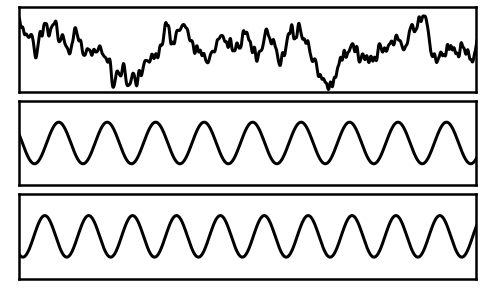

In [13]:
# Plot each component of the complete signal separately
plt_kwargs = {'xlim' : [1, 2], 'ylim' : [-2.5, 2.5], 'lw' : 3, 
              'xlabel' : '', 'ylabel' : ''}
_, axes = plt.subplots(3, 1, figsize=(8, 5))
plot_time_series(times, comp_ap, ax=axes[0], **plt_kwargs)
plot_time_series(times, comp_pe1, ax=axes[1], **plt_kwargs)
plot_time_series(times, comp_pe2, ax=axes[2], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/06-ts-sigcomps.pdf', bbox_inches='tight')

In [14]:
# Simulate signals with aperiodic and only one of the alphas
sig_a1 = sim_combined(n_seconds, fs, comps_a1, comp_vars2)
sig_a2 = sim_combined(n_seconds, fs, comps_a2, comp_vars2)

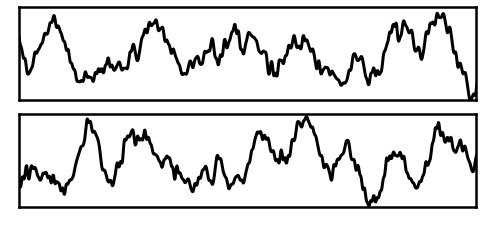

In [15]:
# Plot each component of the alphas, with aperiodic, separately
_, axes = plt.subplots(2, 1, figsize=(8, 4))
plot_time_series(times, sig_a1, ax=axes[0], **plt_kwargs)
plot_time_series(times, sig_a2, ax=axes[1], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.15)
plt.savefig('figures/06-ts-sigalphas.pdf', bbox_inches='tight')

In [16]:
# Simulate the combined signal, with all components
sig = sim_combined(n_seconds, fs, components, comp_vars)

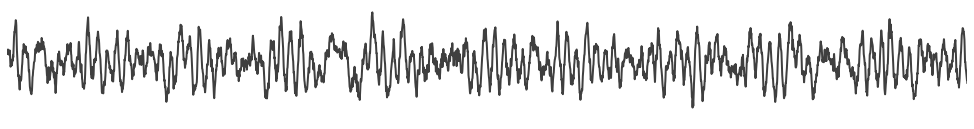

In [17]:
# Plot the combined signal
plot_time_series(times, sig, lw=2, xlim=[10, 20], alpha=0.75)
plt.axis('off')
plt.savefig('figures/06-ts_comb.pdf', bbox_inches='tight')

### Compute Power Spectrum

Next, we will calculate the power spectrum of our simulated, combined signal. 

Note that, in this example, the power spectrum is suggestive / consistent with multiple peaks, but it's not totally clear. 

In [18]:
# Compute the power spectrum of the combined signal 
freqs, powers = compute_spectrum(sig, fs, nperseg=2*fs)
freqs, powers = trim_spectrum(freqs, powers, psd_range)

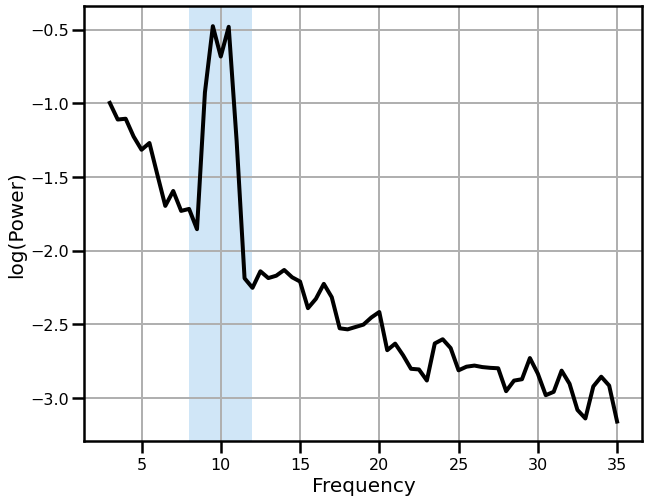

In [19]:
# Plot the power spectrum of the combined signal
plot_spectrum_shading(freqs, powers, alpha_range,
                      log_freqs=False, log_powers=True,
                      lw=4,  color='k', shade_colors=alpha_color)
plt.savefig('figures/06-psd.pdf', bbox_inches='tight')

### Compute Instantaneous Measures

Next we will compute instantaneous measures of the combined signal. 

Note that, in the combined signal, each of the oscillatory components is totally consistent (has no variation across time). 

Any observed variation seen in the instantaneous measures therefore must be arising due the overlap / interference of multiple signals. 

In [20]:
# Filter the combined signal
sig_filt = filter_signal(sig, fs, 'bandpass', alpha_range)

In [21]:
# Compute instantaneous measures on the alpha-filtered 
amp = amp_by_time(sig_filt, fs)
pha = phase_by_time(sig_filt, fs)
fre = freq_by_time(sig_filt, fs)

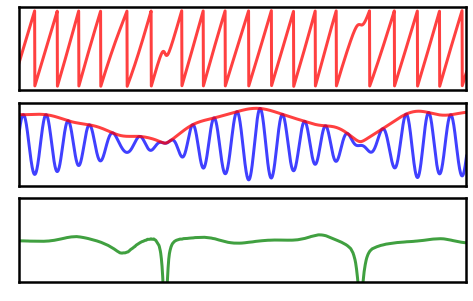

In [22]:
# Plot the instantaneous measures of the combined signal
plt_kwargs= {'xlim' : [14, 16], 'xlabel' : '', 'ylabel' : ''}
_, axes = plt.subplots(3, 1, figsize=(8, 5))
plot_instantaneous_measure(times, pha, 'phase', ax=axes[0], alpha=0.75,
                           colors='r', **plt_kwargs)
plot_instantaneous_measure(times, [sig_filt, amp], 'amplitude', ax=axes[1],
                          colors=['b', 'r'], alpha=[0.75, 0.75], **plt_kwargs)
plot_instantaneous_measure(times, fre, 'frequency', ax=axes[2], alpha=0.75,
                           colors='g', ylim=[2.5, 17.5], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.15)
plt.savefig('figures/06-ts-measures.pdf', bbox_inches='tight')

### Compare Instantaneous Measures

Next, we can quantify and compare the instantaneous measures. 

As a comparison, we will compute instantaneous measures one signals that combine only one of the oscillatory components. 

In [23]:
# Compute instantaneous amplitude on the signals with only one alpha
amp_al1 = amp_by_time(sig_a1, fs, alpha_range)
amp_al2 = amp_by_time(sig_a2, fs, alpha_range)

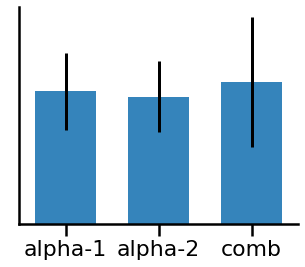

In [24]:
# Compare the measures alpha from the combined and separate signals
_, ax = plt.subplots(figsize=(5, 4))
plot_bar(amp_al1, amp_al2, amp, err=True, labels=labels, ax=ax)
plt.savefig('figures/06-bar_amp.pdf', bbox_inches='tight')

In [25]:
# Check the quantifications of analytic amplitude across the signal & components
print("Alpha comp1,  amp avg  : {:1.2f}, var  : {:1.2f}".format(\
    avg_func(amp_al1), var_func(amp_al1)))
print("Alpha comp2,  amp avg  : {:1.2f}, var  : {:1.2f}".format(\
    avg_func(amp_al2), var_func(amp_al2)))
print("Combined sig, amp avg  : {:1.2f}, var  : {:1.2f}".format(\
    avg_func(amp), var_func(amp)))

Alpha comp1,  amp avg  : 0.90, var  : 0.26
Alpha comp2,  amp avg  : 0.86, var  : 0.24
Combined sig, amp avg  : 0.96, var  : 0.44


In [26]:
# Compute instantaneous frequency of the signal components
fre_al1 = freq_by_time(sig_a1, fs, alpha_range)
fre_al2 = freq_by_time(sig_a2, fs, alpha_range)

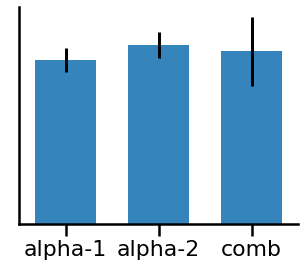

In [27]:
# Plot and compare instantaneous frequency of the signal & components
_, ax = plt.subplots(figsize=(5, 4))
plot_bar(fre_al1, fre_al2, fre, err=True, labels=labels, ax=ax)
plt.savefig('figures/06-bar_freq.pdf', bbox_inches='tight')

In [28]:
# Check the quantifications of analytic frequency across the signal & components
print("Freq (alpha comp1)  - \tavg : {:1.2f} \tvar : {:1.2f}".format(\
    avg_func(fre_al1), var_func(fre_al1)))
print("Freq (alpha comp2)  - \tavg : {:1.2f} \tvar : {:1.2f}".format(\
    avg_func(fre_al2), var_func(fre_al2)))
print("Freq (combined sig) - \tavg : {:1.2f} \tvar : {:1.2f}".format(\
    avg_func(fre), var_func(fre)))

Freq (alpha comp1)  - 	avg : 9.43 	var : 0.69
Freq (alpha comp2)  - 	avg : 10.30 	var : 0.74
Freq (combined sig) - 	avg : 9.92 	var : 1.97


## Conclusion

What is recorded at the electrodes level may reflect multiple sources. 

As we've seen in this example, the combined signal can look much more variable than the underlying components it reflects. 

This stems from how oscillatory signals sum together - and the ways in which they partially cancel each other out.

This means that measures computed on the recorded signal may not directly reflect the underlying signals, but might reflect the ways they interfere with each other. 

To address this, source separation approaches can be used to try to separate different underlying sources, which can then be analyzed separately. 